In [1]:
import sys
import pandas as pd
import seaborn as sns
import scanpy as sc
import numpy as np
import PyComplexHeatmap as pch
import pathlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from matplotlib import cm
from scipy.stats import zscore, linregress, pearsonr
from statsmodels.stats.multitest import fdrcorrection

sc.settings.verbosity = 3         
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

/home/orimosko/.local/lib/python3.8/site-packages/pynndescent/utils.py:202: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(
/home/orimosko/.local/lib/python3.8/site-packages/pynndescent/utils.py:302: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(


scanpy==1.9.8 anndata==0.9.2 umap==0.5.6 numpy==1.23.5 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.10.1 pynndescent==0.5.4


In [95]:
%cd /home/orimosko/projects/phago/B16

/home/orimosko/projects/phago/B16


In [198]:
PHAGO_COLOR = "#FF97E2"
RODOHIGH_COLOR = "#8A54A5"
NONPHAGO_COLOR = "#00A86B"
VIABLE_COLOR = "#63A7FF"

In [466]:
plt.rcParams['pdf.fonttype'] = 42

In [4]:
sys.version

'3.8.19 (default, Mar 20 2024, 19:58:24) \n[GCC 11.2.0]'

In [5]:
sc.settings.figdir = pathlib.PosixPath("plots/")

In [37]:
adata = sc.read_h5ad('/mc_disk2/data/h5ads/phago/B16.h5ad')

In [39]:
adata.shape

(8283, 23389)

In [40]:
adata.obs['Cell_type_full'] = adata.obs.Cell_type.copy()

In [41]:
adata.obs.Cell_type = ['rodo+' if x == 'rodohigh' else x for x in adata.obs.Cell_type]

In [42]:
adata.obs[['Batch.Set.ID', 'Cell_type_full']].value_counts(sort=False)

Batch.Set.ID  Cell_type_full
B16           rodo+             2055
              rodo-             2741
              rodohigh          1368
              viableonly        2119
Name: count, dtype: int64

In [43]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [44]:
sc.pp.log1p(adata)

In [45]:
sc.pp.filter_genes(adata, min_cells=100)

filtered out 15178 genes that are detected in less than 100 cells


In [46]:
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


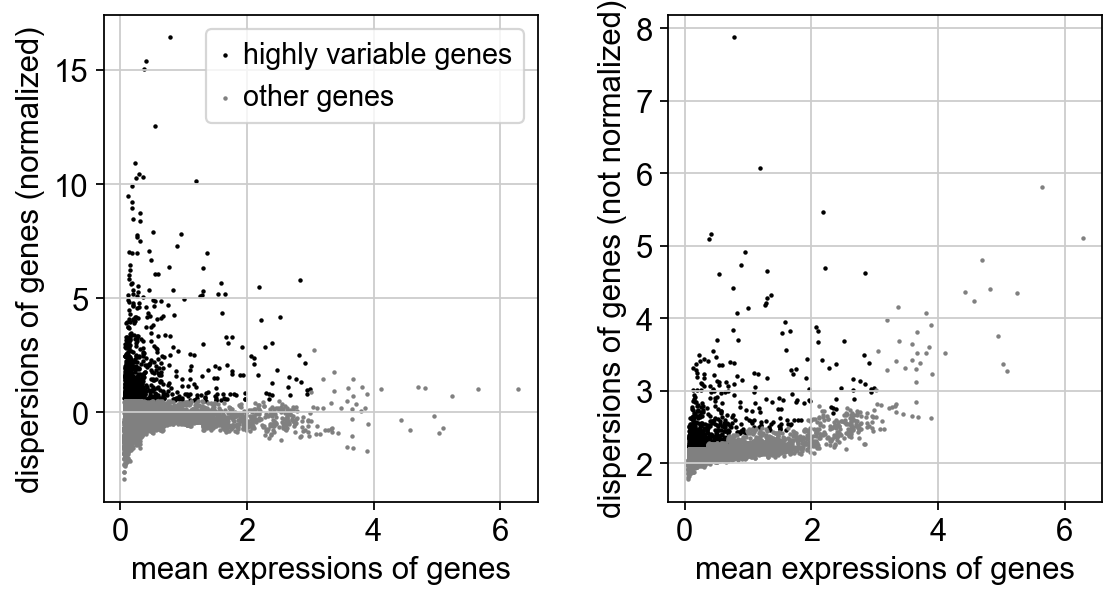

In [47]:
sc.pl.highly_variable_genes(adata)

In [48]:
sc.pp.pca(adata, use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


/home/orimosko/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


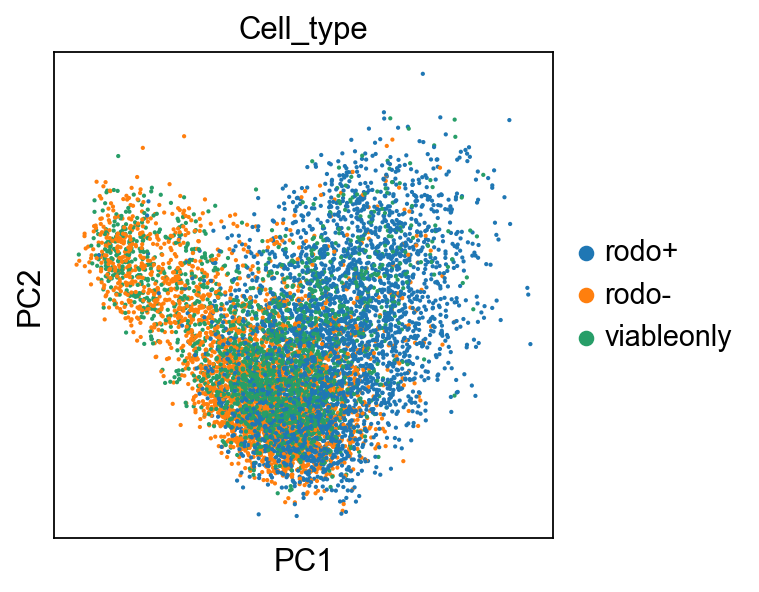

In [49]:
sc.pl.pca(adata, color='Cell_type')

In [50]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:28)


In [51]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [52]:
sc.tl.leiden(adata, resolution=1)

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


In [53]:
adata.obs.Cell_type_full = pd.Categorical(adata.obs.Cell_type_full, 
                                          categories=['viableonly', 'rodo-', 'rodo+', 'rodohigh'], ordered=True)

In [54]:
adata.obs.Cell_type = pd.Categorical(adata.obs.Cell_type, categories=['viableonly', 'rodo-', 'rodo+'], ordered=True)

In [55]:
adata.uns['Cell_type_colors'] = [VIABLE_COLOR, NONPHAGO_COLOR, PHAGO_COLOR]
adata.uns['annots_colors'] = [VIABLE_COLOR, NONPHAGO_COLOR, RODOHIGH_COLOR]
adata.uns['Cell_type_full_colors'] = [VIABLE_COLOR, NONPHAGO_COLOR, PHAGO_COLOR, RODOHIGH_COLOR]

In [63]:
annot_list = ['Macs', 'Macs', 'Macs', 'Macs', 'Macs', 'Macs', 
              'T cells', 'DCs', 'Macs', 'Monocytes', 'Mreg DCs', 'Neutrophils']

In [64]:
annot_order = ['Macs', 'Monocytes', 'DCs', 'Mreg DCs', 'Neutrophils', 'T cells']

In [65]:
adata.obs['annots'] = pd.Categorical([annot_list[int(i)] for i in adata.obs.leiden], categories=annot_order, ordered=True)

In [66]:
manual_genes = {'Macs': ['Adgre1', 'C1qa', 'Apoe', 'Csf1r', 'Mrc1', 'Ccr2'],
                'Monocytes': ['F13a1', 'Retnla', 'Lyz1', 'Ear2'],
                'DCs': ['H2-Aa', 'Cd74', 'Xcr1', 'Cd209a'],
                'Mreg DCs': ['Fscn1', 'Ccl17', 'Ccl22'],
                'Neutrophils': ['Csf3r', 'S100a8', 'Sell'],
                'T cells': ['Ms4a4b', 'Nkg7', 'Gzma']}

/home/orimosko/.local/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


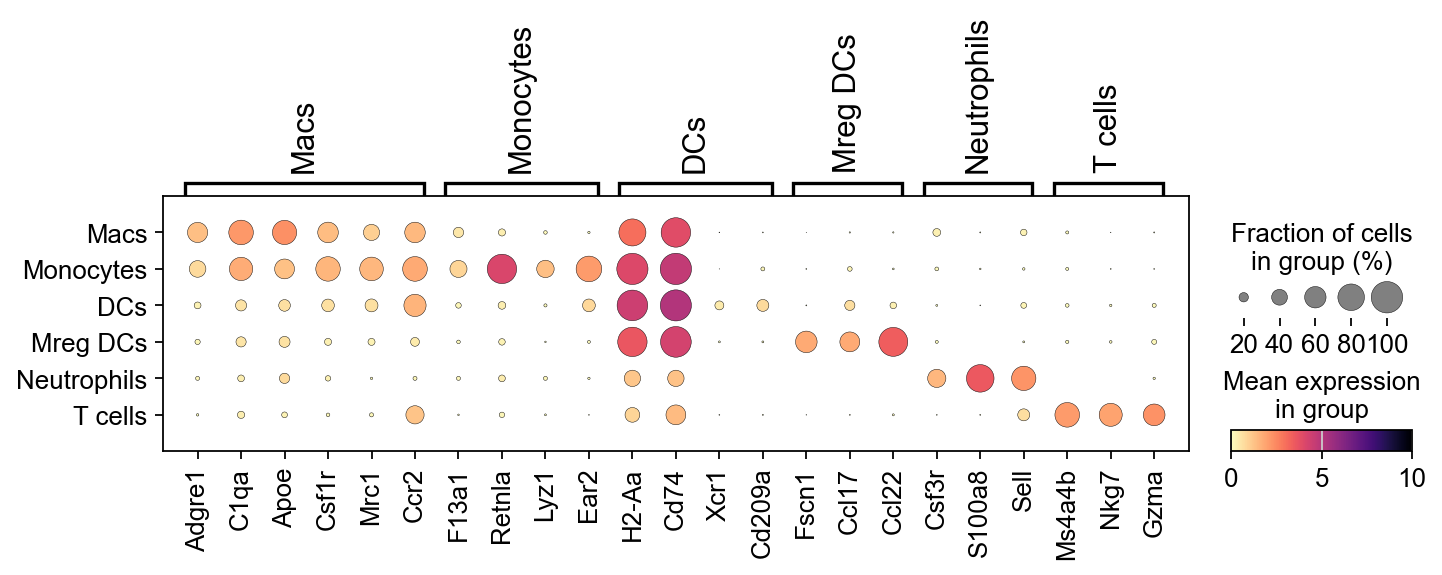

In [67]:
sc.pl.dotplot(adata, manual_genes, groupby="annots", cmap="magma_r", vmin=0, vmax=10, use_raw=False, save='annots_qc.pdf')

/home/orimosko/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


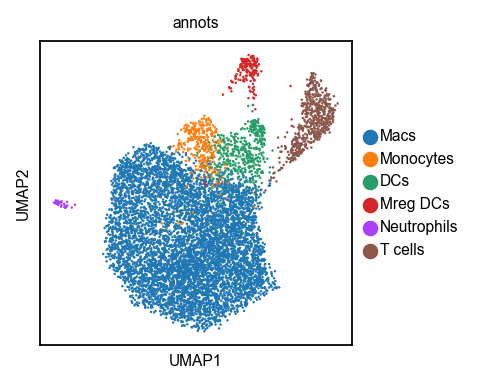

In [335]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
sc.pl.umap(full_adata, color='annots', save='annots_qc.pdf', ax=ax, s=5)

In [68]:
full_adata = adata.copy()

In [87]:
adata = full_adata[full_adata.obs.annots == "Macs"]

In [88]:
adata.write_h5ad('/mc_disk2/data/h5ads/phago/B16_selected.h5ad')

In [12]:
adata = sc.read_h5ad('/mc_disk2/data/h5ads/phago/B16_selected.h5ad')

In [13]:
sc.pp.filter_genes(adata, min_cells=100)

filtered out 733 genes that are detected in less than 100 cells


In [21]:
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


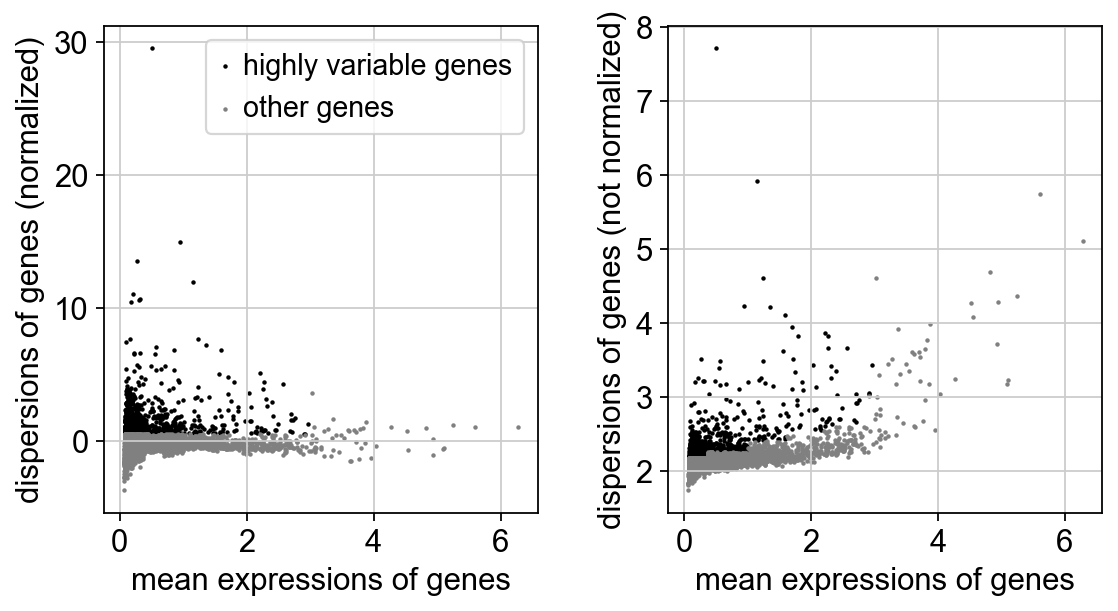

In [22]:
sc.pl.highly_variable_genes(adata)

In [23]:
sc.pp.pca(adata, use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


/home/orimosko/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/orimosko/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


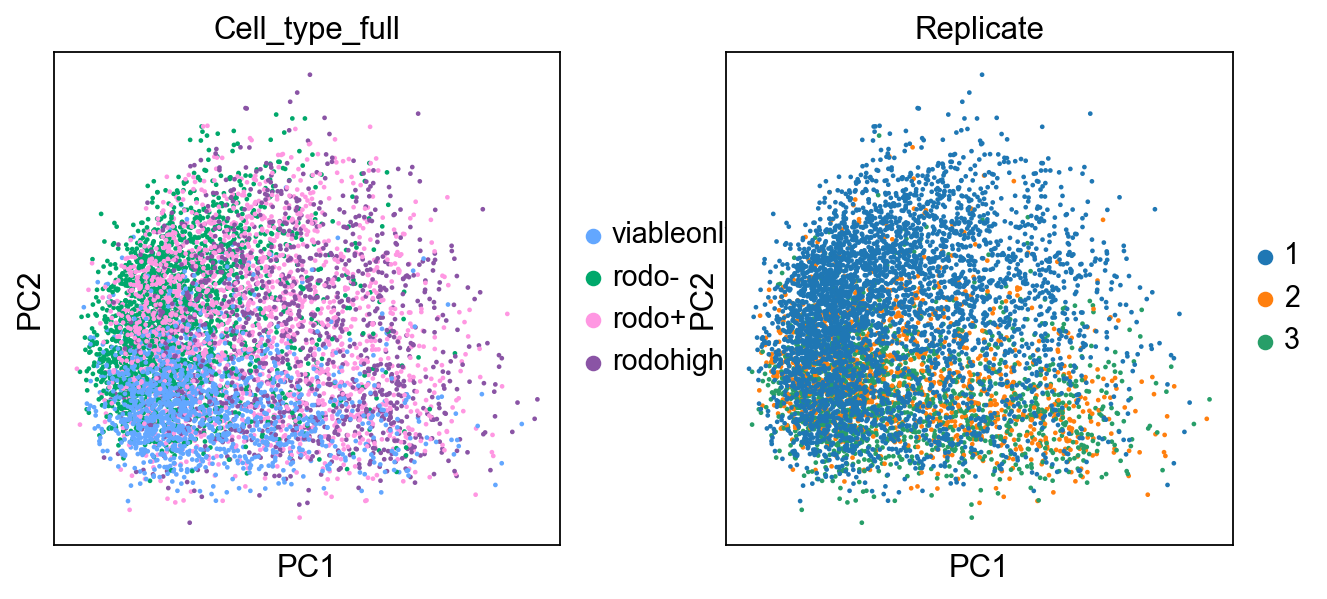

In [24]:
sc.pl.pca(adata, color=['Cell_type_full', 'Replicate'])

In [25]:
sc.external.pp.bbknn(adata, batch_key='Replicate')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [27]:
sc.tl.umap(adata)

computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


In [28]:
sc.tl.leiden(adata, resolution=1)

running Leiden clustering


    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [53]:
annot_list = ['Mac1', 
              'Mac2', 
              'Mac1', 
              'Mac4', 
              'Mac3', 
              'Mac2', 
              'Mac4', 
              'Mac2',
              'Mac2',
              'Mac2']

In [54]:
annot_order = ['Mac1', 'Mac2', 'Mac3', 'Mac4']

In [55]:
adata.obs['annots'] = pd.Categorical([annot_list[int(i)] for i in adata.obs.leiden], categories=annot_order, ordered=True)

In [56]:
#pastels
ANNOT_COLORS = ['#A5D6A7', '#007AC1', '#F9A825', '#E57373']
adata.uns['annots_colors'] = ANNOT_COLORS

/home/orimosko/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


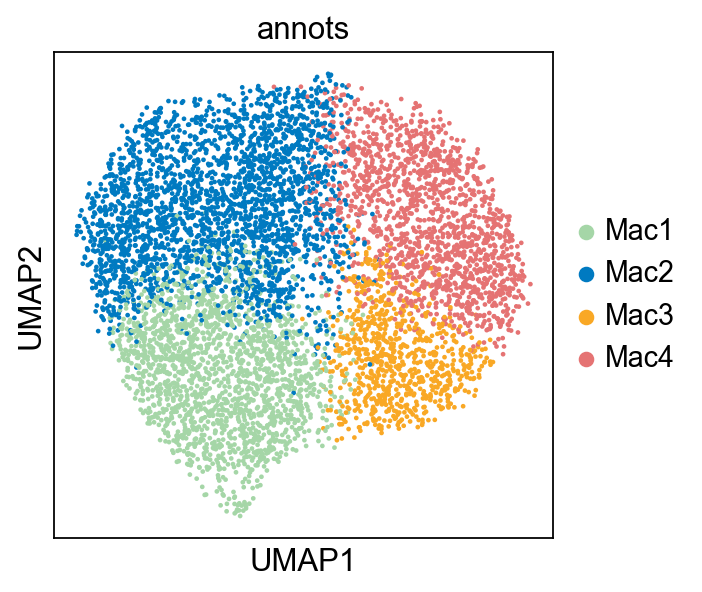

In [57]:
for f in ['annots']:
    sc.pl.umap(adata, color=f, save=f + ".pdf")

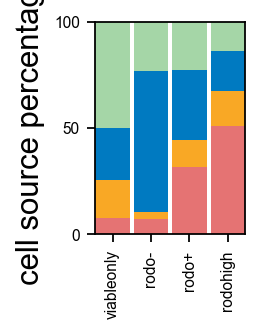

In [192]:
fig, ax = plt.subplots(figsize=(1.2,1.75))
df = pd.DataFrame(index=adata.obs.Cell_type_full.cat.categories,
                  data=[adata[adata.obs.Cell_type_full.values == i, :].obs.annots.value_counts() 
                        for i in adata.obs.Cell_type_full.values.categories])
df = df[['Mac1', 'Mac2', 'Mac3', 'Mac4'][::-1]]
for i in df.index:
    df.loc[i] = 100 * df.loc[i] / np.nansum(df.loc[i])
df.plot(ax=ax, kind="bar", stacked=True, ylabel="cluster", width=0.9, fontsize=7, color=ANNOT_COLORS[::-1])
ax.set_ylabel("cell source percentage")
ax.get_legend().remove()  # Remove the legend
ax.grid(False)
ax.set_ylim((0,100))
ax.set_xlim((-0.45, len(df)-0.55))

#for col in df.columns[:-1]:
#    ax.vlines(100 * sum(adata.obs.annots == col) / len(adata.obs), 
#              ymin=-0.45, ymax=len(df)-0.55, colors="black")
plt.savefig("plots/Cell_type_full_composition.pdf", bbox_inches="tight")

In [ ]:
adata.obs['mac34'] = ["Mac3or4" if x else "Mac1or2" for x in adata.obs.annots.isin(['Mac3', 'Mac4'])]
sc.tl.rank_genes_groups(adata, groupby='mac34')
mac34_dges = sc.get.rank_genes_groups_df(adata,group='Mac3or4')
mac34_dges.to_excel('tables/mac34_dges.xlsx')

# Heatmap

In [ ]:
cdata = adata[adata.obs.Cell_type == "rodo+"]

In [ ]:
cdata.shape

(3164, 7478)

In [ ]:
cell_dict = {}
for ab in cdata.obs["Amp.Batch.ID"].unique():
    index_df = pd.read_csv("index_data/" + ab + ".csv", skiprows=9)[['well', '*YG 586/15 - 570LP-A']]
    for well, facs_index in index_df.values:
        cell_dict[ab + "_" + well] = facs_index

In [ ]:
ab_sb = cdata.obs[['Amp.Batch.ID', 'Batch.Set.ID']].drop_duplicates().set_index('Amp.Batch.ID').to_dict()['Batch.Set.ID']

In [ ]:
scaled_index = pd.DataFrame({'cell': cell_dict.keys(),
                             "batch": [ab_sb[ab.split("_")[0]] for ab in cell_dict.keys()],
                             "FACS_index": cell_dict.values()}).set_index('cell')
scaled_index = scaled_index[scaled_index.index.isin(cdata.obs_names)]

scaled_index['log_FACS_index'] = np.log(scaled_index['FACS_index'])
scaled_index['scaled_index'] = scaled_index.groupby('batch')['log_FACS_index'].transform(lambda x: (x - x.mean()) / x.std())

In [ ]:
cdata = cdata[cdata.obs_names.isin(scaled_index.index)]

In [ ]:
cdata.obs = pd.concat([cdata.obs, scaled_index.loc[cdata.obs.index, ['FACS_index', 'log_FACS_index', 'scaled_index']]], 
                      axis=1)

In [460]:
adata.obs['scaled_index'] = cdata.obs.scaled_index.reindex(adata.obs_names).values

In [461]:
sorted_index = adata.obs.sort_values(by=['annots', 'Cell_type', 'scaled_index']).index

In [462]:
hm_adata = adata[sorted_index]

In [467]:
plt.rcParams.update({'font.size': 7})

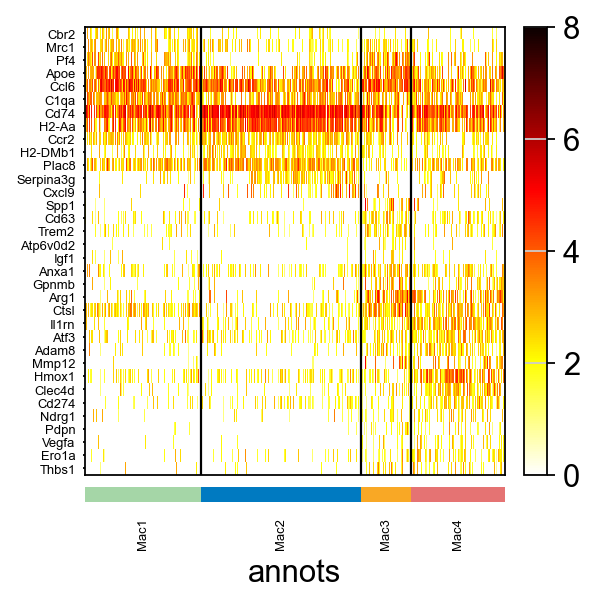

In [469]:
sc.pl.heatmap(hm_adata,
             ['Cbr2', 'Mrc1', 'Pf4', 'Apoe', 'Ccl6', 'C1qa', 
              'Cd74', 'H2-Aa', 'Ccr2', 'H2-DMb1', 'Plac8', 'Serpina3g', 'Cxcl9',
              'Spp1', 'Cd63', 'Trem2', 'Atp6v0d2', 'Igf1',
              'Anxa1', 'Gpnmb', 'Arg1', 'Ctsl', 'Il1rn', 'Atf3', 'Adam8', 'Mmp12',
              'Hmox1', 'Clec4d', 'Cd274','Ndrg1', 'Pdpn',
              'Vegfa', 'Ero1a', 'Thbs1'],
              groupby="annots", dendrogram=False, swap_axes=True,
              cmap="hot_r", vmin=0, vmax=8, show_gene_labels=True, use_raw=False, save='_annot.pdf', figsize=(3.7,4))

In [627]:
annot_df = adata.obs[['Cell_type']]

In [628]:
annot_df['scaled_index'] = cdata.obs.scaled_index.reindex(adata.obs_names).values

/tmp/ipykernel_1466810/2210654585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annot_df['scaled_index'] = cdata.obs.scaled_index.reindex(adata.obs_names).values


In [629]:
annot_df

,Cell_type,scaled_index
AB1528_C24,rodo-,NaN
AB1528_A7,rodo-,NaN
AB1528_K18,rodo-,NaN
AB1528_G20,rodo-,NaN
AB1528_K4,rodo-,NaN
...,...,...
AB1429_L8,rodo+,0.486438
AB1429_A18,rodo+,-0.186999
AB1429_C19,rodo+,1.061993
AB1429_C11,rodo+,-1.439044


In [630]:
cell_type_colors = dict(zip(adata.obs.Cell_type_full.cat.categories, adata.uns['Cell_type_full_colors']))

In [631]:
bwr_cmap = cm.get_cmap("bwr")

/tmp/ipykernel_1466810/268084100.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bwr_cmap = cm.get_cmap("bwr")


In [632]:
vmax = annot_df.scaled_index.abs().max()

In [633]:
norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)

In [634]:
bwr_colors = bwr_cmap(norm(annot_df.scaled_index))

In [635]:
bwr_rgb = [mcolors.to_hex(v) for v in bwr_colors]

In [636]:
bwr_color_dict = dict(zip(annot_df.scaled_index.unique(), np.unique(bwr_rgb)))

In [637]:
color_hm_dict = {'Cell_type_full': cell_type_colors, 'scaled_index': bwr_color_dict}

Starting plotting HeatmapAnnotations


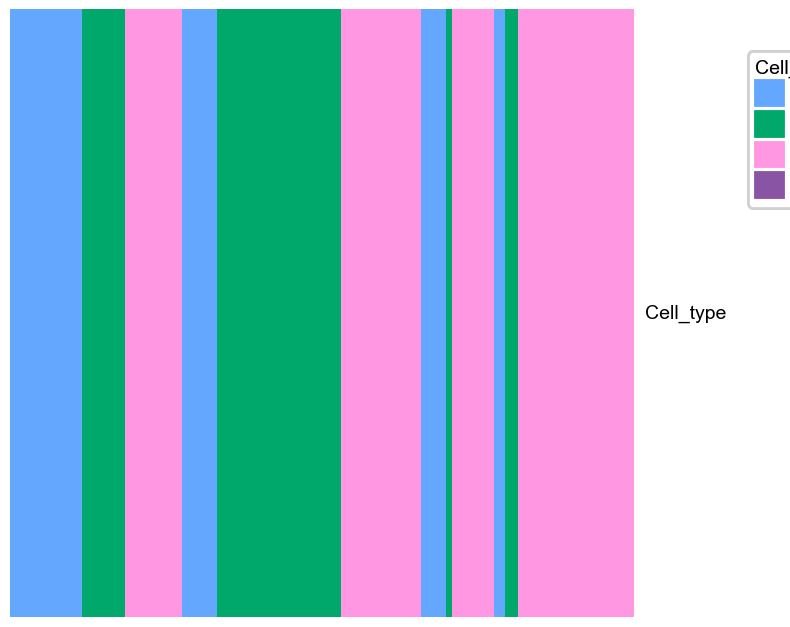

In [640]:
col_ha = pch.HeatmapAnnotation(df=annot_df.loc[sorted_index]['Cell_type'],
                               colors={'Cell_type': cell_type_colors},
                               plot=True,
                               legend=True,
                               legend_gap=5,
                               hgap=0.5,
                               axis=1)
plt.savefig('figures/cell_type_bar.pdf')

Starting plotting HeatmapAnnotations


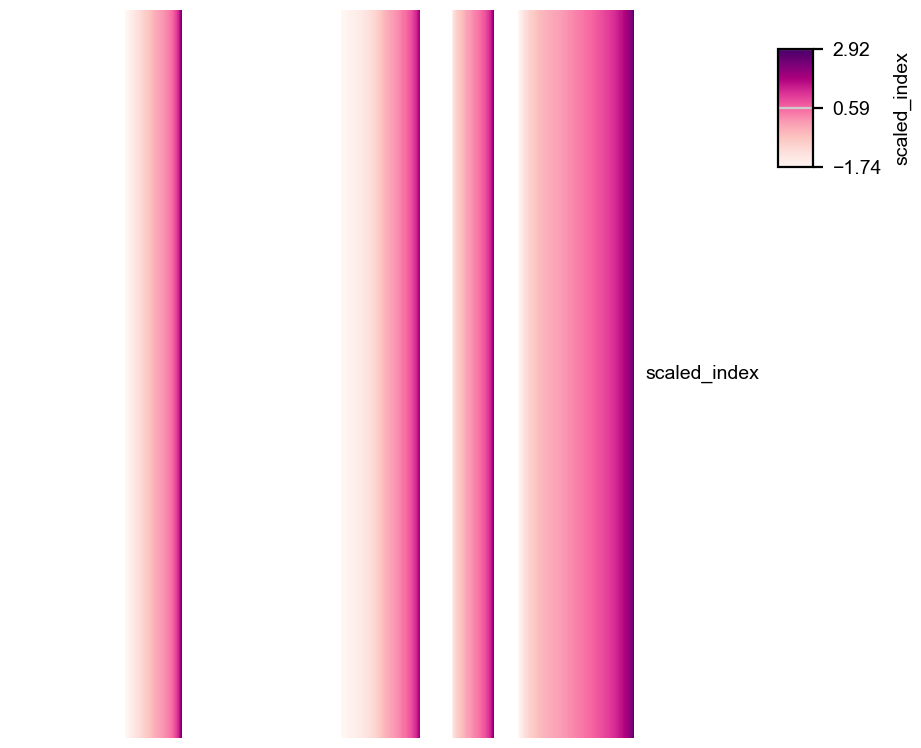

In [641]:
col_ha = pch.HeatmapAnnotation(df=annot_df.loc[sorted_index]['scaled_index'],
                               cmap='RdPu',
                               plot=True,
                               legend=True,
                               legend_gap=5,
                               hgap=0.5,
                               axis=1)
plt.savefig('figures/rodo_bar.pdf')

# Effero score projection

In [194]:
new_up_and_corr_genes = ['Fth1',
 'Wfdc17',
 'Ccl9',
 'Fabp5',
 'Cstb',
 'Marco',
 'Ctsk',
 'Cd63',
 'Lgals3',
 'Lyz2',
 'Esd',
 'Ftl1',
 'Cd68',
 'Rnh1',
 'Ear6',
 'Gpnmb',
 'Mt1',
 'Capg',
 'Tuba1c',
 'Crip1',
 'Acp5',
 'Lgals1',
 'Sod2',
 'Calm1',
 'Calr',
 'Tmsb10',
 'Gapdh',
 'Nme1',
 'Slc39a2',
 'Mrpl52',
 'Emp3',
 'Clec4d',
 'Anxa4',
 'Ctsb',
 'Tyms',
 'Ctsz',
 'Anpep',
 'Tceal9',
 'Msr1',
 'Manf',
 'Ccl17',
 'Cyba',
 'Atp5k',
 'Glrx',
 'Cd24a',
 'Atp6v1c1',
 'Tspo',
 'Calm3',
 'Prdx1',
 'Atp5mpl',
 'Ctsc',
 'Anxa5',
 'Mt2',
 'Bcap31',
 'Hint1',
 'Vat1',
 'Eno1b',
 'Pycard',
 'Aldoa',
 'Cav1',
 'Gla',
 'Fabp4',
 'Nqo2',
 'Atp6v0b',
 'Mfge8',
 'Timm13']

In [195]:
sc.tl.score_genes(adata, new_up_and_corr_genes, score_name='thymo_invivo_score', use_raw=False)

computing score 'thymo_invivo_score'
    finished: added
    'thymo_invivo_score', score of gene set (adata.obs).
    586 total control genes are used. (0:00:00)


/tmp/ipykernel_4186325/1379979494.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(adata.obs, y='thymo_invivo_score', x='Cell_type_full', fill='Cell_type_full',


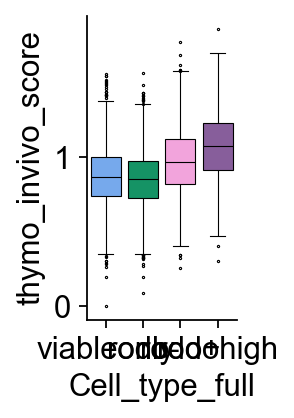

In [196]:
fig, ax = plt.subplots(figsize=(1.2,2.5))
sns.boxplot(adata.obs, y='thymo_invivo_score', x='Cell_type_full', fill='Cell_type_full', 
            palette=[VIABLE_COLOR, NONPHAGO_COLOR, PHAGO_COLOR, RODOHIGH_COLOR],
            boxprops=dict(edgecolor='black', linewidth=0.5), 
            medianprops=dict(color='black', linewidth=0.5), 
            whiskerprops=dict(color='black', linewidth=0.5), 
            capprops=dict(color='black', linewidth=0.5), 
            flierprops=dict(markeredgecolor='black', markersize=0.5))
plt.grid(False)
sns.despine(top=True, right=True)
plt.savefig('plots/invivo_score_boxplot_celltype.pdf')

/tmp/ipykernel_4186325/1502116306.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(adata.obs, y='thymo_invivo_score', x='annots', fill='annots', palette=ANNOT_COLORS,


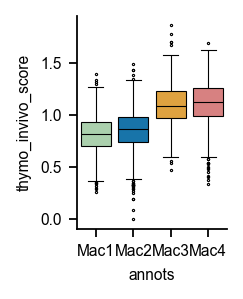

In [201]:
fig, ax = plt.subplots(figsize=(1.2,1.75))
sns.boxplot(adata.obs, y='thymo_invivo_score', x='annots', fill='annots', palette=ANNOT_COLORS,
            boxprops=dict(edgecolor='black', linewidth=0.5), 
            medianprops=dict(color='black', linewidth=0.5), 
            whiskerprops=dict(color='black', linewidth=0.5), 
            capprops=dict(color='black', linewidth=0.5), 
            flierprops=dict(markeredgecolor='black', markersize=0.5))
plt.grid(False)
sns.despine(top=True, right=True)
ax.set_xlabel(ax.get_xlabel(), fontsize=7)
ax.set_ylabel(ax.get_ylabel(), fontsize=7)
ax.tick_params(axis='both', labelsize=7)

plt.savefig('plots/invivo_score_boxplot_annots.pdf')

# For Fig5: pHrodo correlations and effero score

In [385]:
bsdata = cdata.copy()
gene_df = pd.DataFrame(index=bsdata.var_names,
                       columns=['pearson_R', 'p_value'])
for g in gene_df.index:
    gene_df.loc[g] = pearsonr(bsdata.obs.scaled_index, bsdata[:,g].X.todense().A1)

In [386]:
gene_df['p_val_corr'] = fdrcorrection(gene_df.p_value)[1]
gene_df['-log10(qval)'] = -np.log10(gene_df['p_val_corr'].astype('float'))
plt.axhline(-np.log10(0.05),color="grey",linestyle="--")
p.figure.savefig("figures/scaled_pearson_volcano.png")
gene_df.to_csv('tables/scaled_index_pearson_all.csv')

In [ ]:
gene_order = ["Clec4d", 
              "Tmsb10", 
              "Ctsk", 
              "Aldoa", "Eno1b", 
              "Prdx1",
              "Fth1", "Ftl1",
              "Gpnmb", "Spp1", "Il1rn", "Pdpn", 
              "Pkm", "Pgk1", "Slc2a1", "Tpi1",
              "Arg1", "Adam8", "Mmp12", "Mmp13", 
              "Pmp22", "Prdx6",
              "Thbs1", "Vegfa", "Ero1a", 
              "Cd274"]

In [286]:
hm_df = cdata[:,gene_order].to_df().iloc[np.argsort(cdata.obs.scaled_index)]

In [287]:
scaled_hm_df = zscore(hm_df)

In [291]:
quantile_means = pd.DataFrame([chunk.mean() for chunk in np.array_split(scaled_hm_df, 100)]).T

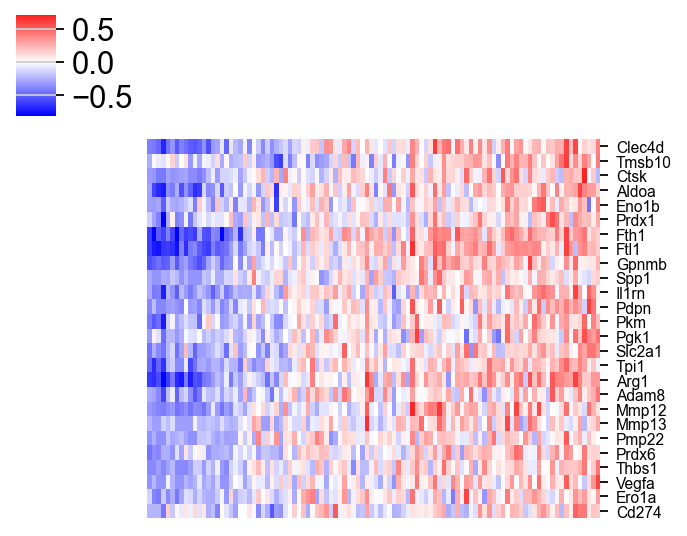

In [293]:
g = sns.clustermap(quantile_means.loc[gene_order], cmap='bwr', center=0, col_cluster=False, row_cluster=False,
               xticklabels=False, yticklabels=True, figsize=(5,3.5))
g.ax_heatmap.grid(False)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.tick_params(axis='y', labelsize=7) 
plt.savefig('figures/scaled_binned_rodo_hm.pdf')


In [358]:
vdata = adata[adata.obs.Cell_type == "viableonly"].copy()

In [359]:
vdata.shape

(1538, 7478)

In [360]:
sc.tl.score_genes(vdata, gene_list=new_up_and_corr_genes, score_name="effero_score", use_raw=False)

computing score 'effero_score'
    finished: added
    'effero_score', score of gene set (adata.obs).
    634 total control genes are used. (0:00:00)


In [387]:
rodo_gene_df = gene_df.copy()

In [388]:
gene_df = pd.DataFrame(index=vdata.var_names, columns=['pearson_r', 'pearson_p'])

In [390]:
for gene in vdata.var_names:
    x = vdata.obs['effero_score'].values
    y = vdata[:, gene].X.todense().A1
    pearson_r, pearson_p = pearsonr(x, y)
    gene_df.loc[gene] = [pearson_r, pearson_p]

In [396]:
hm_df = vdata[:,gene_order].to_df().iloc[np.argsort(vdata.obs.effero_score)]

In [397]:
scaled_hm_df = zscore(hm_df)

In [399]:
quantile_means = pd.DataFrame([chunk.mean() for chunk in np.array_split(scaled_hm_df, 100)]).T

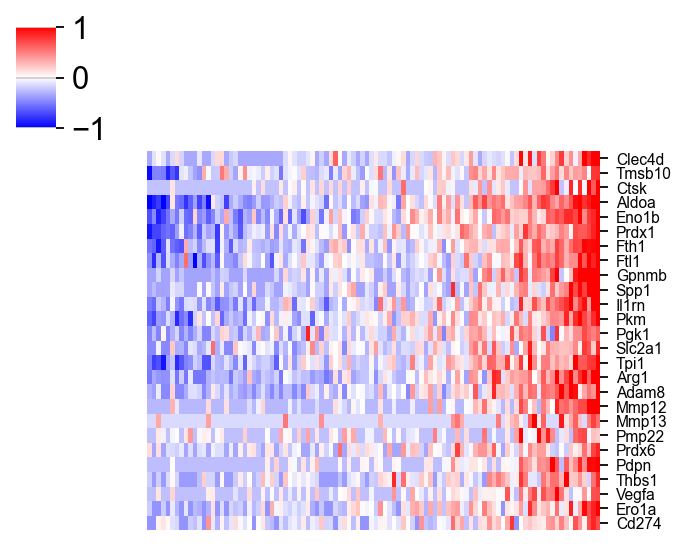

In [440]:
g = sns.clustermap(quantile_means.loc[gene_order], cmap='bwr', center=0, vmin=-1, vmax=1, col_cluster=False, row_cluster=False,
               xticklabels=False, yticklabels=True, figsize=(5,3.5))
g.ax_heatmap.grid(False)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.tick_params(axis='y', labelsize=7) 
plt.savefig('figures/scaled_binned_viable_effero_hm.pdf')


In [420]:
corr_df = pd.DataFrame([rodo_gene_df.pearson_R.values, gene_df.pearson_r.values], columns=gene_df.index, index=['rodo_R', 'score_R']).T

In [422]:
corr_df = corr_df[~corr_df.index.isin(new_up_and_corr_genes)]

In [429]:
highlight_genes = corr_df.index[(corr_df.rodo_R > 0.15) & (corr_df.score_R > 0.15)]

In [431]:
highlight_genes = np.union1d(highlight_genes, corr_df.index[(corr_df.rodo_R > 0.25) | (corr_df.score_R > 0.25)])

In [442]:
highlight_genes = np.union1d(highlight_genes, ['H2-Aa', 'Cd74', 'Ccr2', 'Ccl8', 'H2-Eb1', 'Ifitm2', 'Ifitm3', 'C1qa', 'C1qb', 'C1qc',
                                               'Vegfa', 'Cd274'])

In [443]:
highlight_genes

array(['Adam8', 'Anxa1', 'Anxa2', 'Arg1', 'Atp6v0d2', 'Basp1', 'C1qa',
       'C1qb', 'C1qc', 'Ccl8', 'Ccr2', 'Cd274', 'Cd74', 'Ctsd', 'Ctsl',
       'Ctss', 'Emp1', 'Eno1', 'Gm7336', 'Gpi1', 'H2-Aa', 'H2-Eb1',
       'Hilpda', 'Hmox1', 'Id2', 'Ifitm2', 'Ifitm3', 'Il1rn', 'Il7r',
       'Ldha', 'Lhfpl2', 'Litaf', 'Mif', 'Mmp12', 'Pdpn', 'Pkm', 'Rgs1',
       'Sdcbp', 'Slc2a1', 'Spp1', 'Tpi1', 'Vegfa', 'Vim'], dtype=object)

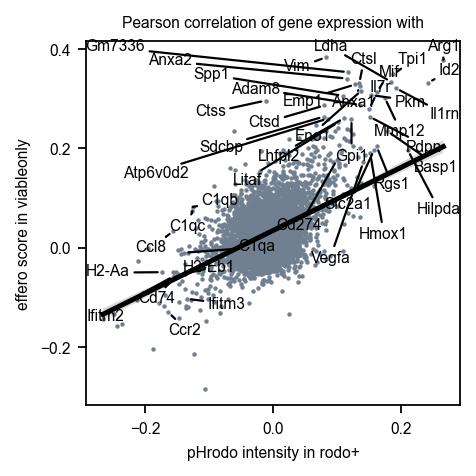

In [444]:
plt.figure(figsize=(3,3))
sns.regplot(corr_df, x='rodo_R', y='score_R',
            scatter_kws={'color': 'slategray', 'alpha':1, 's':1},
            line_kws={'color': 'black'})
texts = [plt.text(x=corr_df.loc[pl, 'rodo_R'],  fontsize=7,
                  y=corr_df.loc[pl, 'score_R'], s=pl) 
         for pl in highlight_genes]
adjust_text(texts, expand_text=(1.2, 2), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
            arrowprops=dict(arrowstyle='-', color='black')) # ensure the labeling is clear by adding arrows
#plt.hlines()
#plt.xlim(-5, 3)
#plt.ylim(-5, 3)

plt.title('Pearson correlation of gene expression with', fontsize=7)
plt.xlabel('pHrodo intensity in rodo+', fontsize=7)
plt.xticks(fontsize=7)
plt.ylabel('effero score in viableonly', fontsize=7)
plt.yticks(fontsize=7)
plt.grid(False)
plt.savefig('figures/rodo_vs_effero_corr.pdf')

In [ ]:
phrodo = pd.read_csv('tables/scaled_index_pearson_all.csv', index_col=0)
phrodo = phrodo[phrodo.columns[:-1]]
phrodo.columns = ['pHrodo ' + col for col in phrodo.columns]

In [ ]:
mac34 = pd.read_excel('tables/mac34_dges.xlsx', index_col=1)
mac34 = mac34[mac34.columns[1:]]
mac34.columns = ['Mac3or4 vs Mac1or2 ' + col for col in mac34.columns]
mac34.sort_index(inplace=True)

In [ ]:
merged = pd.merge(mac34, phrodo, left_index=True, right_index=True, how='outer')

In [ ]:
gene_df['adjusted_pearson_p'] = fdrcorrection(gene_df.pearson_p.values)[1]

/tmp/ipykernel_4186325/103580718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_df['adjusted_pearson_p'] = fdrcorrection(gene_df.pearson_p.values)[1]


In [ ]:
gene_df.columns = ['EfferoScore ' + col for col in gene_df.columns]

In [ ]:
merged = pd.merge(merged, gene_df, left_index=True, right_index=True, how='outer')

In [ ]:
merged.to_excel('tables/Supp4.xlsx')